In [3]:
import pandas as pd
import numpy as np

### Data management

In [4]:
absolute_path = '../data/data_post_comptetition/'

# to add split.json
original_dataset_path = {
    'ArMIS': absolute_path + 'ArMIS_dataset/ArMIS_',
    'ConvAbuse': absolute_path + 'ConvAbuse_dataset/ConvAbuse_',
    'Brexit': absolute_path + 'HS-Brexit_dataset/HS-Brexit_',
    'MD': absolute_path + 'MD-Agreement_dataset/MD-Agreement_',
}

dfs = {}

for name in original_dataset_path:
    dfs[name] = pd.concat([
        pd.read_json(original_dataset_path[name] + 'train.json', orient = 'index'),
        pd.read_json(original_dataset_path[name] + 'dev.json', orient = 'index'),
        pd.read_json(original_dataset_path[name] + 'test.json', orient = 'index'),
    ]).loc[:, ['text', 'number of annotations', 'hard_label', 'soft_label', 'split']]

### Extracting Level of Disagreement (LoD)

In [27]:
def disagrement_level(n_annotators):
    if n_annotators % 2 == 0:
        return (.5, .5)
    else:
        middle_num = n_annotators / 2
        return (
            round(np.floor(middle_num) / n_annotators, 1), 
            round(np.ceil(middle_num) / n_annotators, 1),
        )


def get_disagreement(soft_label, n_annotators):
    if soft_label['0'] == 0 or soft_label['1'] == 0:
        return 0    # no disagreement
    dis_level = [round(x, 1) for x in disagrement_level(n_annotators)]
    if round(soft_label['0'], 1) in dis_level:
        return 1    # disagreement
    else:
        return 2    # slighty disagreement


# disagrement_level(3)
get_disagreement({'0': .5, '1': .5}, 6)

1

In [28]:
dfs['Brexit']['soft_label']

1      {'0': 1.0, '1': 0.0}
2      {'0': 1.0, '1': 0.0}
3      {'0': 1.0, '1': 0.0}
4      {'0': 1.0, '1': 0.0}
5      {'0': 1.0, '1': 0.0}
               ...         
164    {'0': 1.0, '1': 0.0}
165    {'0': 0.5, '1': 0.5}
166    {'0': 0.5, '1': 0.5}
167    {'0': 1.0, '1': 0.0}
168    {'0': 1.0, '1': 0.0}
Name: soft_label, Length: 1120, dtype: object

In [34]:
for name in dfs:
    dfs[name]['disagreement_lev'] = dfs[name].apply(lambda x: get_disagreement(x['soft_label'], x['number of annotations']), axis = 1)

In [39]:
# storing to disk
for name in dfs:
    dfs[name].to_csv(f'../data/{name}_LoD.csv')

### Stats

In [174]:
import matplotlib.pyplot as plt
palette = ['#DFD9E2', '#C3ACCE', '#89909F', '#538083', '#2A7F62']

In [103]:
counts = {}
for name in dfs:
    counts[name] = {}
    for split in ['train', 'dev', 'test']:
        counts[name][split] = [
            sum(dfs[name][dfs[name]['split'] == split]['disagreement_lev'] == 0),   # agreement
            sum(dfs[name][dfs[name]['split'] == split]['disagreement_lev'] == 1),   # disagreement
            sum(dfs[name][dfs[name]['split'] == split]['disagreement_lev'] == 2),   # slightly disagreement/agreement
        ]

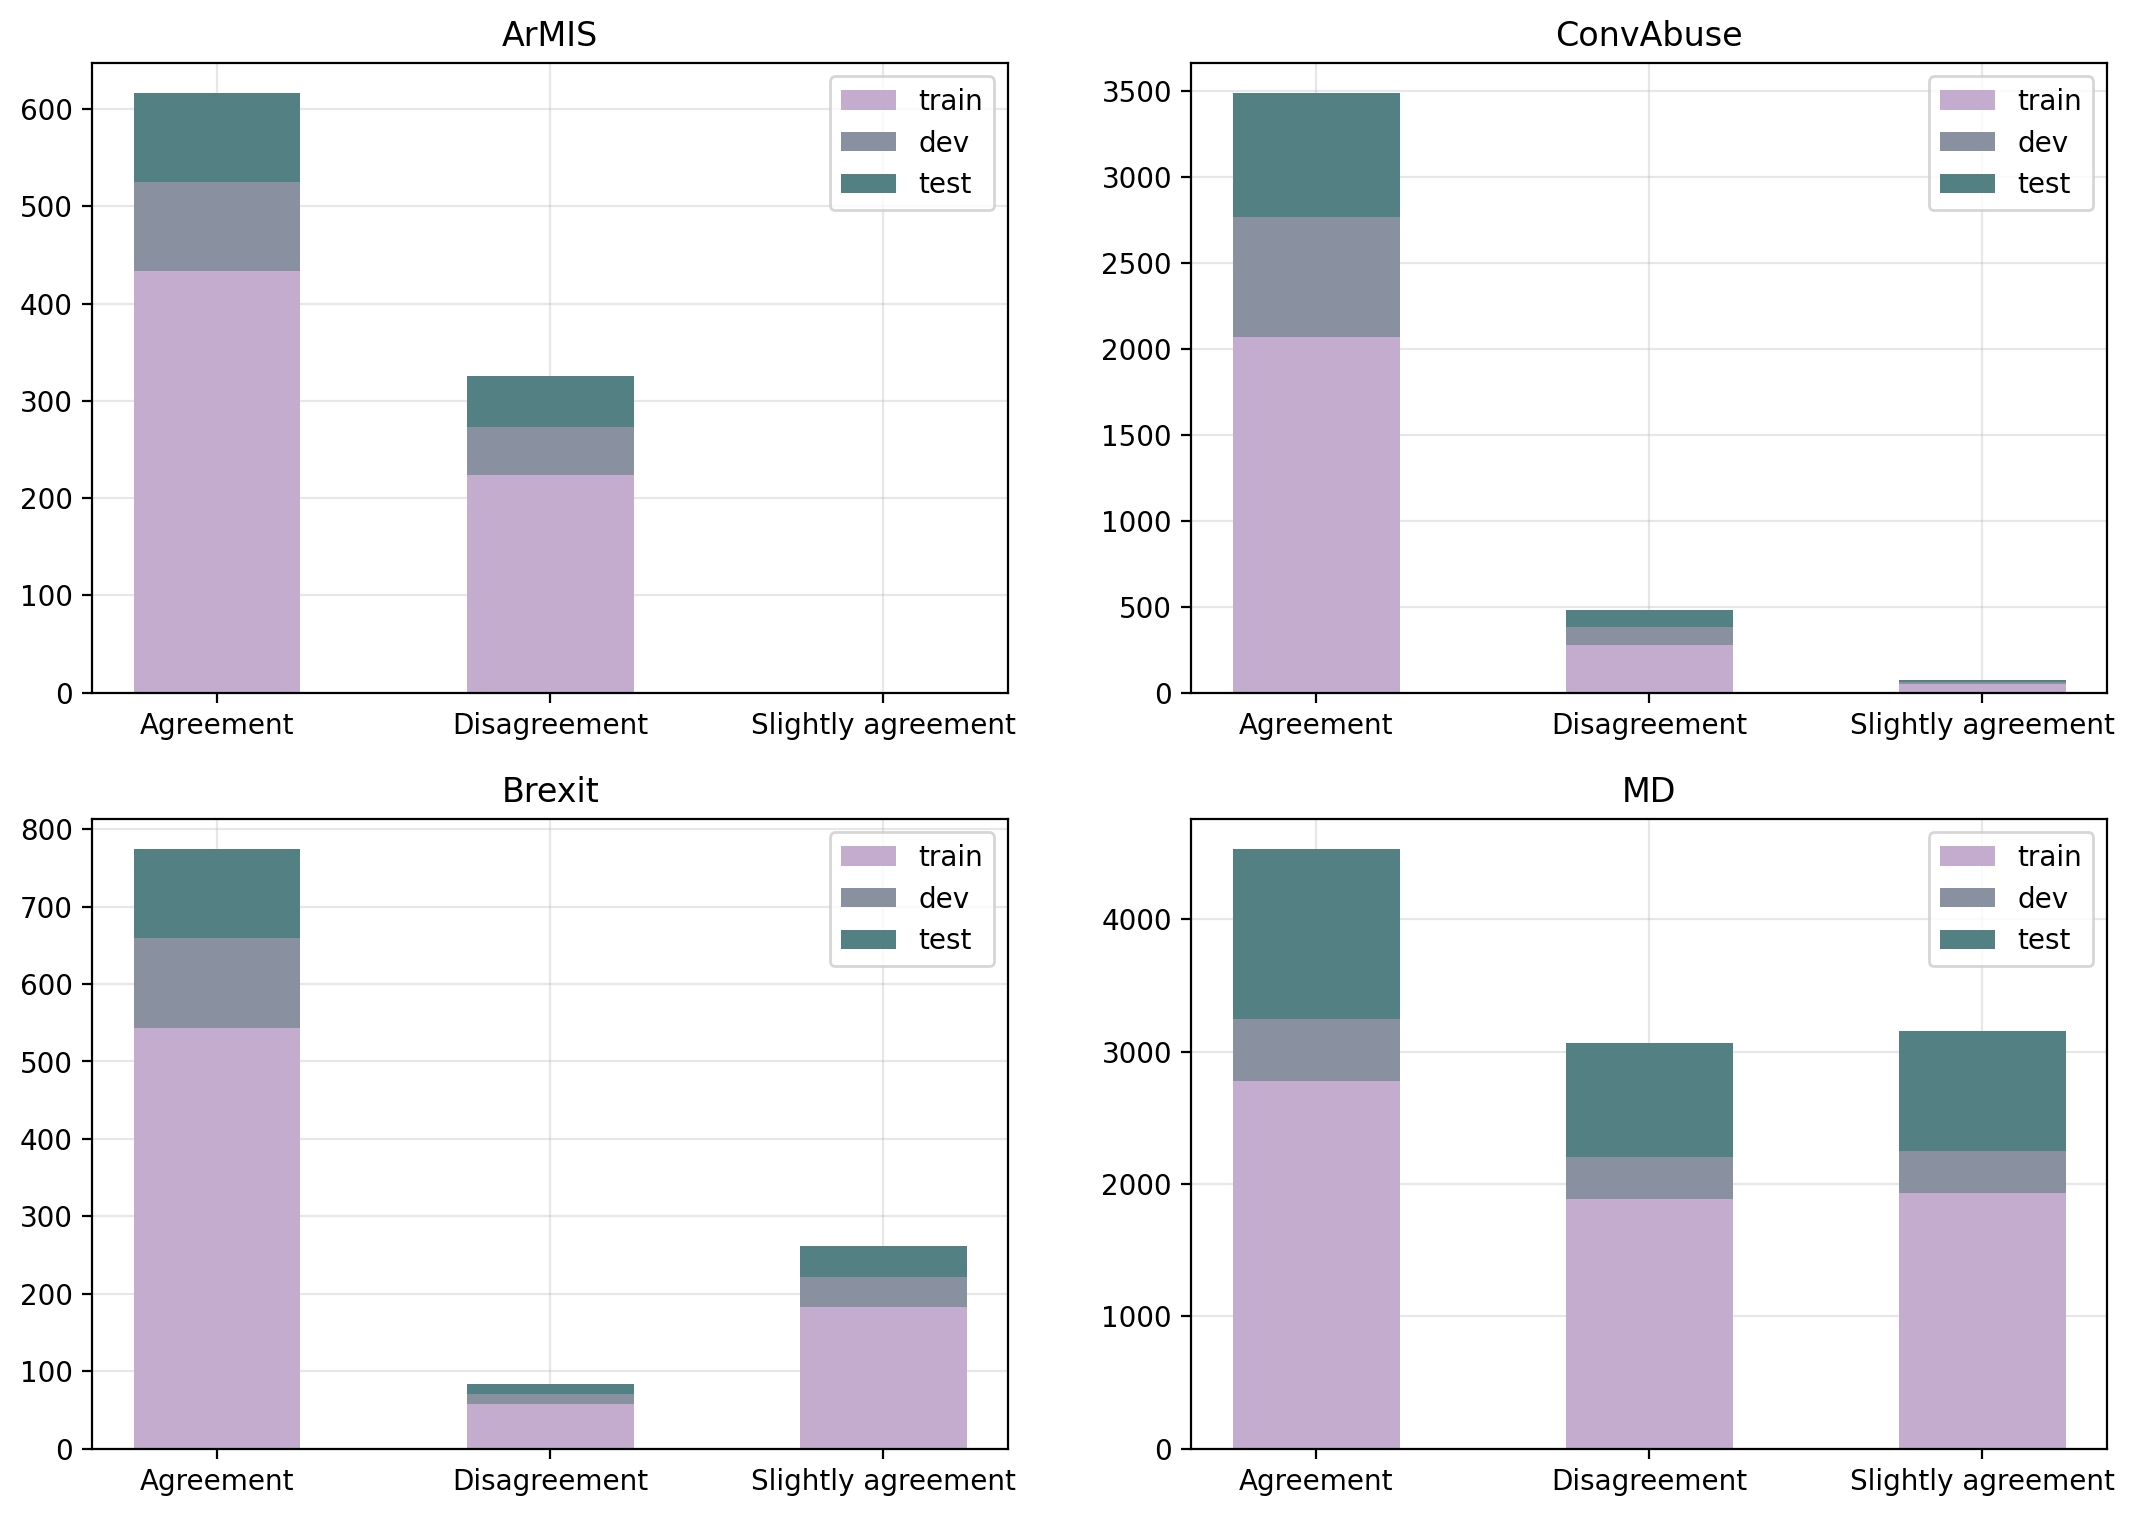

In [189]:
disag_labels = (
    'Agreement',
    'Disagreement',
    'Slightly agreement',
)
width = 0.5
plt.figure(figsize=(13, 9), dpi = 200)

for i, name in enumerate(dfs, start = 1):
    plt.subplot(2, 2, i)

    bottom = np.zeros(3)
    for (boolean, weight_count), c in zip(counts[name].items(), palette[1:4]):
        plt.bar(disag_labels, weight_count, width, label=boolean, bottom=bottom, color = c, zorder = 2)
        bottom += weight_count
    
    # plt.ylim(0, 4800)
    plt.grid(alpha = .3, zorder = 0)
    
    plt.title(name)
    plt.legend(loc = "upper right")

plt.show()